# Incidence de la varicelle

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1984 et se termine avec une semaine récente.

In [2]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

In [6]:
local_path = 'incidence_varicelle.csv'
if os.path.exists(local_path):
    raw_data = pd.read_csv(local_path)
else:
    raw_data = pd.read_csv(data_url, skiprows=1)
    raw_data.to_csv(local_path)  # Save the original CSV file without the comment in the first line

raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202025          7    261        0     660       0           0   
1     202024          7    391        0     965       1           0   
2     202023          7    558        1    1115       1           0   
3     202022          7    277        0     633       0           0   
4     202021          7    602       36    1168       1           0   
5     202020          7    824       20    1628       1           0   
6     202019          7    310        0     753       0           0   
7     202018          7    849       98    1600       1           0   
8     202017          7    272        0     658       0           0   
9     202016          7    758       78    1438       1           0   
10    202015          7   1918      675    3161       3           1   
11    202014          7   3879     2227    5531       6           3   
12    202013          7   7326     5236    9416      11           8   
13    202012          7   8123     5790   10456      12           8   
14    202011          7  10198     7568   12828      15          11   
15    202010          7   9011     6691   11331      14          10   
16    202009          7  13631    10544   16718      21          16   
17    202008          7  10424     7708   13140      16          12   
18    202007          7   8959     6574   11344      14          10   
19    202006          7   9264     6925   11603      14          10   
20    202005          7   8505     6314   10696      13          10   
21    202004          7   7991     5831   10151      12           9   
22    202003          7   5968     4100    7836       9           6   
23    202002          7   6534     4530    8538      10           7   
24    202001          7   9835     7019   12651      15          11   
25    201952          7   7941     5246   10636      12           8   
26    201951          7   5823     3675    7971       9           6   
27    201950          7   6424     4276    8572      10           7   
28    201949          7   6621     4540    8702      10           7   
29    201948          7   5542     3383    7701       8           5   
...      ...        ...    ...      ...     ...     ...         ...   
1512  199126          7  17608    11304   23912      31          20   
1513  199125          7  16169    10700   21638      28          18   
1514  199124          7  16171    10071   22271      28          17   
1515  199123          7  11947     7671   16223      21          13   
1516  199122          7  15452     9953   20951      27          17   
1517  199121          7  14903     8975   20831      26          16   
1518  199120          7  19053    12742   25364      34          23   
1519  199119          7  16739    11246   22232      29          19   
1520  199118          7  21385    13882   28888      38          25   
1521  199117          7  13462     8877   18047      24          16   
1522  199116          7  14857    10068   19646      26          18   
1523  199115          7  13975     9781   18169      25          18   
1524  199114          7  12265     7684   16846      22          14   
1525  199113          7   9567     6041   13093      17          11   
1526  199112          7  10864     7331   14397      19          13   
1527  199111          7  15574    11184   19964      27          19   
1528  199110          7  16643    11372   21914      29          20   
1529  199109          7  13741     8780   18702      24          15   
1530  199108          7  13289     8813   17765      23          15   
1531  199107          7  12337     8077   16597      22          15   
1532  199106          7  10877     7013   14741      19          12   
1533  199105          7  10442     6544   14340      18          11   
1534  199104          7   7913     4563   11263      14           8   
1535  199103          7  15387    10484   20290      27          18   
1536  199102          7  16277  

Point manquant ?

In [10]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

In [11]:
data = raw_data  # no data is excluded

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [12]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il reste deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [14]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

In [16]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

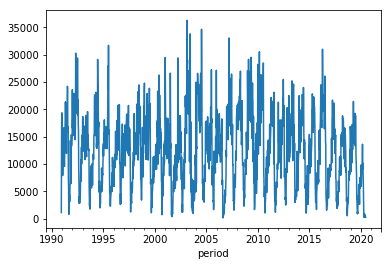

In [17]:
sorted_data['inc'].plot()

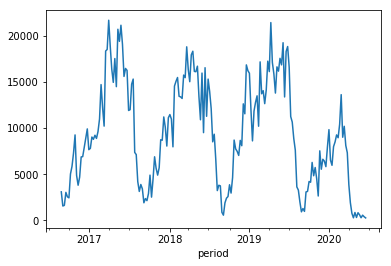

In [18]:
sorted_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Nous définissons la période de référence du 1er septembre de l'année $N$ au
1er septembre de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er septembre de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er septembre.

Encore un petit détail: les données commencent en décembre 1990, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1991.

In [35]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W') for y in range(1991, sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [36]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    try:
        assert abs(len(one_year)-52) < 2
    except AssertionError:
        print(len(one_year), week1, week2)
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

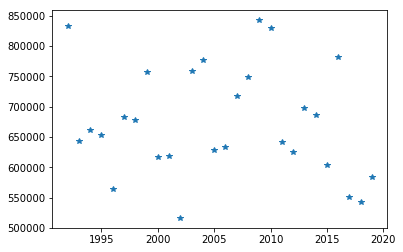

In [37]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (au début).

In [42]:
yearly_incidence.sort_values(ascending=False)

2009    842373
1992    832939
2010    829911
2016    782114
2004    777388
2003    758363
1999    756456
2008    749478
2007    717352
2013    698332
2014    685769
1997    683434
1998    677775
1994    661409
1995    652478
1993    643387
2011    642368
2006    632833
2005    628464
2012    624573
2001    619041
2000    617597
2015    604382
2019    584066
1996    564901
2017    551041
2018    542312
2002    516689
dtype: int64

Enfin, un histogramme montre bien que les épidémies de varicelle ont une intensité assez régulière d'année en année

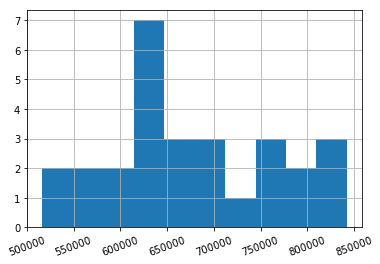

In [43]:
yearly_incidence.hist(xrot=20)